## Import the necessary libraries

In [159]:
# import libraries
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import json # library to handle JSON files
import matplotlib.pyplot as plt
import seaborn as sns

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Get the crime data

In [2]:
# pull crime data down
sf_crime_url = 'https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD'
sf_crime_all = pd.read_csv(sf_crime_url)

In [3]:
# Real dataset is 200k+ items. Let's cap to 2000 items while working so that the notebook performs a bit quicker.
#sf_crime=sf_crime_all.head(2000).copy()
sf_crime=sf_crime_all.copy()
sf_crime.shape

(211858, 34)

There are a lot of columns in the dataset.

In [378]:
sf_crime_all.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites)
0,2018/12/02 12:45:00 AM,2018/12/02,00:45,2018,Sunday,2018/12/02 01:56:00 AM,74374327130,743743,180908554,183360210.0,...,-122.404795,"(37.78490829943, -122.40479506276)",32.0,5.0,10.0,8.0,NaN,NaN,NaN,NaN
1,2018/12/01 08:30:00 PM,2018/12/01,20:30,2018,Saturday,2018/12/01 09:18:00 PM,74370071000,743700,180908112,183353564.0,...,-122.408036,"(37.786409612811, -122.408036237445)",19.0,6.0,3.0,36.0,NaN,NaN,1.0,NaN
2,2019/03/18 02:01:00 PM,2019/03/18,14:01,2019,Monday,2019/03/18 02:21:00 PM,78164004134,781640,190194129,190772267.0,...,-122.406699,"(37.756833733806, -122.406699002688)",53.0,3.0,2.0,20.0,3.0,NaN,NaN,NaN
3,2019/03/20 08:00:00 AM,2019/03/20,08:00,2019,Wednesday,2019/03/20 02:06:00 PM,78169706244,781697,190199583,190792201.0,...,-122.404865,"(37.78400661242, -122.404864795177)",32.0,1.0,10.0,34.0,NaN,NaN,NaN,NaN
4,2019/03/12 01:30:00 PM,2019/03/12,13:30,2019,Tuesday,2019/03/15 06:02:00 PM,78154706372,781547,196055103,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop unneeded columns
sf_crime.drop(columns=['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Filed Online',
       'Resolution', 'Intersection', 'CNN', 'Report Type Code', 'Report Type Description', 'Incident Code',
       'point', 'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods', 'Supervisor District',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Parks Alliance CPSI (27+TL sites)', 'Incident Subcategory', 'Incident Description', 'Police District', 'Analysis Neighborhood'],
              inplace=True)

In [48]:
# Many rows don't have lat-long, making them useless for this analysis. Dropping those rows.
sf_crime.dropna(subset=['Latitude', 'Longitude', 'Incident Category'], inplace=True)

In [49]:
sf_crime.shape

(142588, 6)

In [50]:
sf_crime.head()

,Incident Category,Latitude,Longitude,LatBucket,LongBucket,LatLongBucket
0,Lost Property,37.786410,-122.408036,12,13,12_13
1,Assault,37.756834,-122.406699,8,14,8_14
2,Larceny Theft,37.784007,-122.404865,12,14,12_14
3,Lost Property,37.800190,-122.441177,15,9,15_9
4,Disorderly Conduct,37.708311,-122.420083,0,12,0_12


Looking at the list of categories, there is some cleanup needed to remove certain groupings and de-duplicate others.

In [51]:
sf_crime['Incident Category'].unique()

array(['Lost Property', 'Assault', 'Larceny Theft', 'Disorderly Conduct',
       'Robbery', 'Weapons Offense', 'Motor Vehicle Theft',
       'Malicious Mischief', 'Drug Offense', 'Fraud', 'Burglary',
       'Civil Sidewalks', 'Stolen Property', 'Prostitution',
       'Offences Against The Family And Children', 'Traffic Collision',
       'Juvenile Offenses', 'Homicide', 'Traffic Violation Arrest',
       'Forgery And Counterfeiting', 'Vandalism', 'Weapons Carrying Etc',
       'Family Offense', 'Suicide', 'Arson', 'Fire Report', 'Sex Offense',
       'Embezzlement', 'Motor Vehicle Theft?', 'Rape', 'Drug Violation',
       'Human Trafficking, Commercial Sex Acts', 'Weapons Offence',
       'Human Trafficking (A), Commercial Sex Acts', 'Liquor Laws',
       'Gambling'], dtype=object)

Clean up incident categories.

In [56]:
# remove non-crime incident types
categories_to_drop = ['Other', 'Other Offenses', 'Non-Criminal', 'Case Closure', 'Courtesy Report',
                      'Lost Property', 'Miscellaneous Investigation', 'Missing Person', 'Other Miscellaneous',
                     'Recovered Vehicle', 'Suspicious', 'Suspicious Occ', 'Vehicle Impounded', 'Vehicle Misplaced',
                     'Warrant', 'Suicide', 'Fire Report', 'Human Trafficking, Commercial Sex Acts', 'Human Trafficking (A), Commercial Sex Acts']
for cat in categories_to_drop:
    sf_crime=sf_crime[sf_crime['Incident Category'] != cat]

# reset the index after dropping all these rows
sf_crime=sf_crime.reset_index(drop=True)

# Quick look at the categories included
sf_crime['Incident Category'].unique()

array(['Assault', 'Larceny Theft', 'Disorderly Conduct', 'Robbery',
       'Weapons Offense', 'Motor Vehicle Theft', 'Malicious Mischief',
       'Drug Offense', 'Fraud', 'Burglary', 'Civil Sidewalks',
       'Stolen Property', 'Prostitution',
       'Offences Against The Family And Children', 'Traffic Collision',
       'Juvenile Offenses', 'Homicide', 'Traffic Violation Arrest',
       'Forgery And Counterfeiting', 'Vandalism', 'Weapons Carrying Etc',
       'Family Offense', 'Arson', 'Sex Offense', 'Embezzlement',
       'Motor Vehicle Theft?', 'Rape', 'Drug Violation', 'Weapons Offence',
       'Liquor Laws', 'Gambling'], dtype=object)

## Breaking the analysis area into buckets for analysis

The city will be broken down into a rectangular grid, with the number of crimes of each type mapped to that grid.

In [58]:
# define the number of buckets, and the label for each bucket
lat_buckets = 20
lat_bucket_labels = [i for i in range(lat_buckets)]

long_buckets = 20
long_bucket_labels = [i for i in range(long_buckets)]

In [59]:
# calculate the latitude and longitude bucket for each report. lat_bins and long_bins will contain a list of the bucket edges for each bin
sf_crime['LatBucket'], lat_bins = pd.cut(sf_crime['Latitude'], lat_buckets, labels=lat_bucket_labels, retbins=True)
sf_crime['LongBucket'], long_bins = pd.cut(sf_crime['Longitude'], long_buckets, labels=long_bucket_labels, retbins=True)

# create a column containing a single value for the overall bin
sf_crime['LatLongBucket'] = sf_crime['LatBucket'].astype(str) + "_" + sf_crime['LongBucket'].astype(str)

In [60]:
sf_crime.head()

,Incident Category,Latitude,Longitude,LatBucket,LongBucket,LatLongBucket
0,Assault,37.756834,-122.406699,8,14,8_14
1,Larceny Theft,37.784007,-122.404865,12,14,12_14
2,Disorderly Conduct,37.708311,-122.420083,0,12,0_12
3,Robbery,37.760101,-122.421425,8,12,8_12
4,Weapons Offense,37.773025,-122.410692,10,13,10_13


## Calculate the total number of crimes by category for each bucket

First apply one-hot encoding.

In [62]:
crime_hot = pd.get_dummies(sf_crime['Incident Category'])

Now group the data by LatLongBucket, summing so that we can get a count by category.

In [138]:
sf_crime_encoded = sf_crime.join(crime_hot)
sf_crime_encoded['Total Crimes'] = 1

In [139]:
crime_rollup = sf_crime_encoded.groupby(['LatLongBucket']).sum()
crime_rollup.drop(columns=['Latitude', 'Longitude'], inplace=True)

In [140]:
crime_rollup=crime_rollup.reset_index(drop=False)
crime_rollup.head()

,LatLongBucket,Arson,Assault,Burglary,Civil Sidewalks,Disorderly Conduct,Drug Offense,Drug Violation,Embezzlement,Family Offense,...,Robbery,Sex Offense,Stolen Property,Traffic Collision,Traffic Violation Arrest,Vandalism,Weapons Carrying Etc,Weapons Offence,Weapons Offense,Total Crimes
0,0_1,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,34
1,0_10,0.0,24.0,15.0,0.0,6.0,0.0,0.0,0.0,1.0,...,12.0,0.0,0.0,0.0,9.0,0.0,2.0,0.0,1.0,145
2,0_11,0.0,10.0,4.0,0.0,5.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,94
3,0_12,12.0,110.0,27.0,0.0,22.0,16.0,3.0,0.0,3.0,...,36.0,4.0,4.0,0.0,19.0,0.0,19.0,0.0,25.0,586
4,0_13,1.0,35.0,24.0,0.0,13.0,2.0,0.0,0.0,3.0,...,19.0,0.0,0.0,1.0,5.0,1.0,10.0,0.0,9.0,331


In [96]:
crime_rollup.describe()

,Arson,Assault,Burglary,Civil Sidewalks,Disorderly Conduct,Drug Offense,Drug Violation,Embezzlement,Family Offense,Forgery And Counterfeiting,...,Robbery,Sex Offense,Stolen Property,Traffic Collision,Traffic Violation Arrest,Vandalism,Weapons Carrying Etc,Weapons Offence,Weapons Offense,Total
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,...,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,1.779026,46.779026,35.299625,2.423221,13.655431,20.891386,0.239700,0.970037,1.037453,3.539326,...,18.561798,2.187266,4.149813,1.419476,10.741573,0.928839,4.367041,0.026217,4.138577,509.086142
std,3.470587,99.822549,48.471759,24.392404,21.758267,118.458232,1.045325,2.368147,1.683205,6.644670,...,40.182279,13.650943,7.414679,2.083789,23.822745,1.367793,10.095787,0.201652,7.739624,804.683796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,7.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,108.000000
50%,1.000000,16.000000,21.000000,0.000000,6.000000,3.000000,0.000000,0.000000,0.000000,1.000000,...,7.000000,0.000000,2.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,219.000000
75%,2.000000,49.000000,42.000000,0.000000,16.500000,9.000000,0.000000,1.000000,1.000000,3.500000,...,19.000000,2.000000,4.000000,2.000000,9.500000,1.000000,4.000000,0.000000,5.000000,573.000000
max,33.000000,1095.000000,409.000000,379.000000,195.000000,1451.000000,13.000000,22.000000,10.000000,54.000000,...,396.000000,220.000000,65.000000,12.000000,194.000000,6.000000,107.000000,2.000000,58.000000,6152.000000


## Get data from Foursquare

Set up Foursquare ids.

In [74]:
# The code was removed by Watson Studio for sharing.

In [75]:
#CLIENT_ID = 'client-id' # your Foursquare ID
#CLIENT_SECRET = 'client-secret' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version

Define a function to get venues for a bucket.

In [225]:
def getVenueCountByCat(sw_lat, sw_long, ne_lat, ne_long, catId):
    # returns the number of venues within the specified category in the square specified by the lat-long coordinates
    LIMIT=1000
    
    url = 'https://api.foursquare.com/v2/venues/search?&intent=browse&client_id={}&client_secret={}&v={}&sw={},{}&ne={},{}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        sw_lat, 
        sw_long,
        ne_lat, 
        ne_long, 
        LIMIT,
        catId)

    venues = requests.get(url).json()['response']['venues']
    dataframe = json_normalize(venues)
        
    return(len(dataframe))   

Run through the bins, getting the count of venues for each category.

In [276]:
# define a list of Foursquare's top-level categories, with ID for each
categories = [['Arts and Entertainment', '4d4b7104d754a06370d81259'],
['College & University', '4d4b7105d754a06372d81259'],
['Event', '4d4b7105d754a06373d81259'],
['Food', '4d4b7105d754a06374d81259'],
['Nightlife Spot', '4d4b7105d754a06376d81259'],
['Outdoors & Recreation', '4d4b7105d754a06377d81259'],
['Professional & Other Places', '4d4b7105d754a06375d81259'],
['Residence','4e67e38e036454776db1fb3a'],
['Shop & Service','4d4b7105d754a06378d81259'],
['Travel & Transport','4d4b7105d754a06379d81259']]

# Create a dataframe to store the results for each
# First column will have the latlongbucket
venue_summary=pd.DataFrame(columns=['LatLongBucket'])

# Add columns for each of the other categories in the list
for cat in categories:
    venue_summary[cat[0]]=""

for lat_bin in range(lat_buckets): #replace lat_buckets with 4 for testing
    for long_bin in range(long_buckets): #replace long_buckets with 4 for testing
        current_row = len(venue_summary)
        latlongbucket = str(lat_bin) + "_" + str(long_bin)
        venue_summary.loc[current_row,'LatLongBucket'] = latlongbucket
        row_sum = 0
        # progress display
        if long_bin ==0:
            print('bucket: ', latlongbucket,
                  'lat_bin:', lat_bin,
                  " sw =", lat_bins[lat_bin], long_bins[long_bin],
                  "ne = ", lat_bins[lat_bin+1], long_bins[long_bin+1])

        for cat in categories:
            # get the id for the category
            cat_id = cat[1]
            
            # call foursquare for the venue count in this grid square
            #venue_count = cat_id
            venue_count = getVenueCountByCat(sw_lat=lat_bins[lat_bin],
                            sw_long=long_bins[long_bin],
                            ne_lat=lat_bins[lat_bin+1],
                            ne_long=long_bins[long_bin+1],
                            catId = cat_id)
            
            # insert the value into the dataframe
            venue_summary.loc[current_row, cat[0]] = venue_count
            row_sum += venue_count
            
        # update sum
        venue_summary.loc[current_row, 'Total Venues'] = row_sum

print('Venue counts retrieved.')
venue_summary.head()

bucket:  0_0 lat_bin: 0  sw = 37.7078662567 -122.511442478 ne =  37.714088384 -122.503917318
bucket:  1_0 lat_bin: 1  sw = 37.714088384 -122.511442478 ne =  37.7201885087 -122.503917318
bucket:  2_0 lat_bin: 2  sw = 37.7201885087 -122.511442478 ne =  37.7262886335 -122.503917318
bucket:  3_0 lat_bin: 3  sw = 37.7262886335 -122.511442478 ne =  37.7323887583 -122.503917318
bucket:  4_0 lat_bin: 4  sw = 37.7323887583 -122.511442478 ne =  37.7384888831 -122.503917318
bucket:  5_0 lat_bin: 5  sw = 37.7384888831 -122.511442478 ne =  37.7445890078 -122.503917318
bucket:  6_0 lat_bin: 6  sw = 37.7445890078 -122.511442478 ne =  37.7506891326 -122.503917318
bucket:  7_0 lat_bin: 7  sw = 37.7506891326 -122.511442478 ne =  37.7567892574 -122.503917318
bucket:  8_0 lat_bin: 8  sw = 37.7567892574 -122.511442478 ne =  37.7628893822 -122.503917318
bucket:  9_0 lat_bin: 9  sw = 37.7628893822 -122.511442478 ne =  37.7689895069 -122.503917318
bucket:  10_0 lat_bin: 10  sw = 37.7689895069 -122.511442478 n

,LatLongBucket,Arts and Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Total Venues
0,0_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0_1,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0
2,0_2,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,5.0
3,0_3,1.0,0.0,0.0,3.0,0.0,7.0,3.0,0.0,1.0,2.0,17.0
4,0_4,0.0,2.0,0.0,1.0,0.0,2.0,9.0,0.0,0.0,0.0,14.0


## Combine the datasets

In [277]:
analysis_df = pd.merge(venue_summary, crime_rollup, on = 'LatLongBucket')
analysis_df.head()

,LatLongBucket,Arts and Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,...,Robbery,Sex Offense,Stolen Property,Traffic Collision,Traffic Violation Arrest,Vandalism,Weapons Carrying Etc,Weapons Offence,Weapons Offense,Total Crimes
0,0_1,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,34
1,0_3,1.0,0.0,0.0,3.0,0.0,7.0,3.0,0.0,1.0,...,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,29
2,0_5,1.0,0.0,0.0,5.0,3.0,11.0,8.0,7.0,8.0,...,6.0,0.0,1.0,0.0,6.0,0.0,1.0,0.0,0.0,121
3,0_6,3.0,0.0,0.0,1.0,1.0,5.0,5.0,1.0,6.0,...,10.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,152
4,0_7,0.0,1.0,0.0,16.0,3.0,10.0,13.0,2.0,37.0,...,13.0,1.0,0.0,1.0,9.0,0.0,7.0,0.0,5.0,269


# Analysis

Let's plot the venue count against the crime total.

In [278]:
# drop any rows where total crimes == 0 (there are some buckets that are in the sea)
analysis_df=analysis_df[analysis_df['Total Crimes'] > 0]

analysis_df.apply(pd.to_numeric, errors='ignore')

# force values to numeric
#analysis_df['Venue Count']=analysis_df['Venue Count'].apply(pd.to_numeric)
#analysis_df['Total Crimes']=analysis_df['Total Crimes'].apply(pd.to_numeric)

# reset the index after dropping rows
analysis_df=analysis_df.reset_index(drop=True)

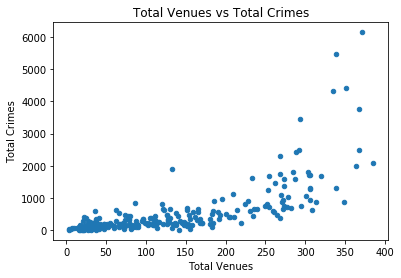

In [279]:
analysis_df.plot(kind='scatter', x='Total Venues', y='Total Crimes')

plt.title('Total Venues vs Total Crimes')
plt.xlabel('Total Venues')
plt.ylabel('Total Crimes')

plt.show()

### Fit a linear model and analyze

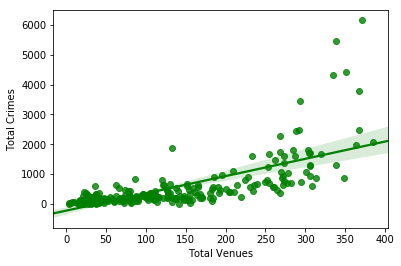

In [280]:
ax = sns.regplot(x='Total Venues', y='Total Crimes', data=analysis_df, color='green')

This looks promising - there is some correlation between the total number of crime incidents and the total number of venues in each location.

## Exploring correlation between different sub-types
Let's take a look at the different variables and look for items with high degrees of correlation

In [308]:
temp_matrix = analysis_df.corr().copy()

# We'll cut down the rows and columns so that the crime categories are in the columns and the venue types in the rows

# drop columns for individual categories
for cat in categories:
    temp_matrix.drop(columns=cat[0], inplace=True)

# drop totals column
temp_matrix.drop(columns='Total Venues', inplace=True)

# pull out the rows for which we have a category
cat_names = []
for cat in categories:
    cat_names.append(cat[0])

corr_matrix = temp_matrix.loc[cat_names]

# it's easier to read transposed
transp_matrix = corr_matrix.transpose()
transp_matrix

,Arts and Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Arson,0.410360,0.346494,0.476531,0.442063,0.458507,0.331606,0.336719,0.490822,0.387257,0.372894
Assault,0.458158,0.388833,0.494967,0.531204,0.469284,0.380210,0.353402,0.579771,0.389076,0.419635
Burglary,0.613083,0.542196,0.429378,0.652744,0.693915,0.596678,0.493106,0.695954,0.508714,0.633407
Civil Sidewalks,0.125781,0.060342,-0.013021,0.149211,0.186984,0.111703,0.106872,0.086334,0.142458,0.174215
Disorderly Conduct,0.512455,0.406096,0.427836,0.594109,0.530426,0.447230,0.413119,0.609989,0.447563,0.484149
Drug Offense,0.248876,0.184847,0.287788,0.298084,0.226386,0.321145,0.194336,0.422648,0.173638,0.169410
Drug Violation,0.264052,0.195387,0.446235,0.293022,0.296382,0.212396,0.195054,0.383098,0.177056,0.216623
Embezzlement,0.456691,0.480998,0.457370,0.457230,0.395709,0.382569,0.393739,0.383809,0.377628,0.389492
Family Offense,0.218857,0.106675,0.114459,0.299482,0.273666,0.132342,0.174238,0.349694,0.248852,0.203618
Forgery And Counterfeiting,0.509397,0.450433,0.393233,0.596895,0.554399,0.448794,0.395891,0.621518,0.446348,0.513551


Let's create a heatmap of the correlations.

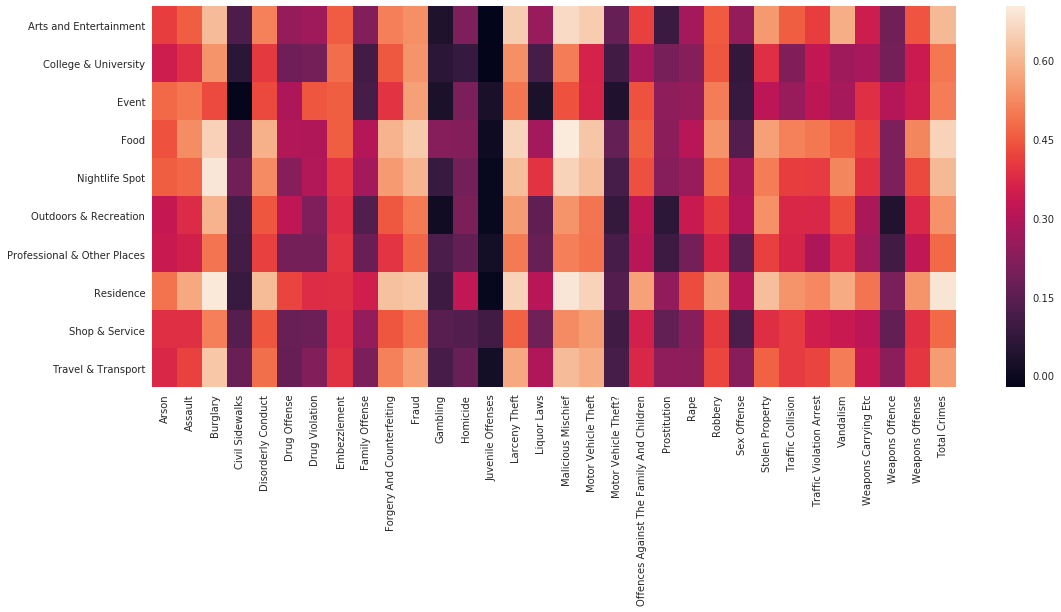

In [307]:
sns.set(rc={'figure.figsize':(18,7)})
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=cat_names)

It looks like there's some stronger correlations on certain categories. For example, the number of residences is fairly strongly correlated with the number of burglaries and malicious mischief reported. This could be an area for future exploration.

For now let's look just at modeling the Total Crimes.

In [309]:
total_corr = corr_matrix['Total Crimes'].copy()
total_corr

Arts and Entertainment         0.608578
College & University           0.497027
Event                          0.506816
Food                           0.656209
Nightlife Spot                 0.608501
Outdoors & Recreation          0.541738
Professional & Other Places    0.474160
Residence                      0.690965
Shop & Service                 0.475970
Travel & Transport             0.558462
Name: Total Crimes, dtype: float64

It looks like the strongest relationships are Arts & Entertainment, Food, Nightlife Spot and Residence. Let's plot these individually.

### Total Crimes vs Art & Entertainment venues

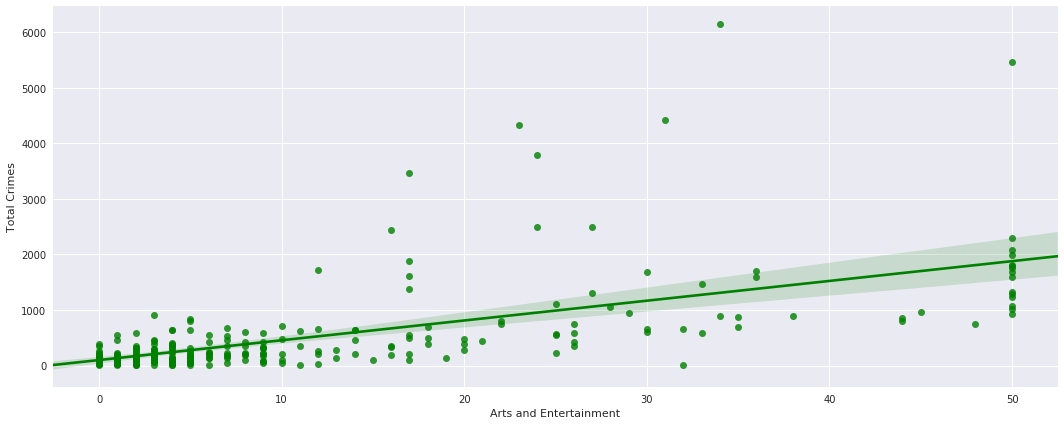

In [310]:
ax = sns.regplot(x='Arts and Entertainment', y='Total Crimes', data=analysis_df, color='green')

### Total Crimes vs Food venues
In this chart and the one above for Arts & Entertainment we can see that there is an extra clustering of bins that contain at least 50 locations - this is due to the limitations imposed by the Foursquare service that cap the number of items that can be returned in some cases.

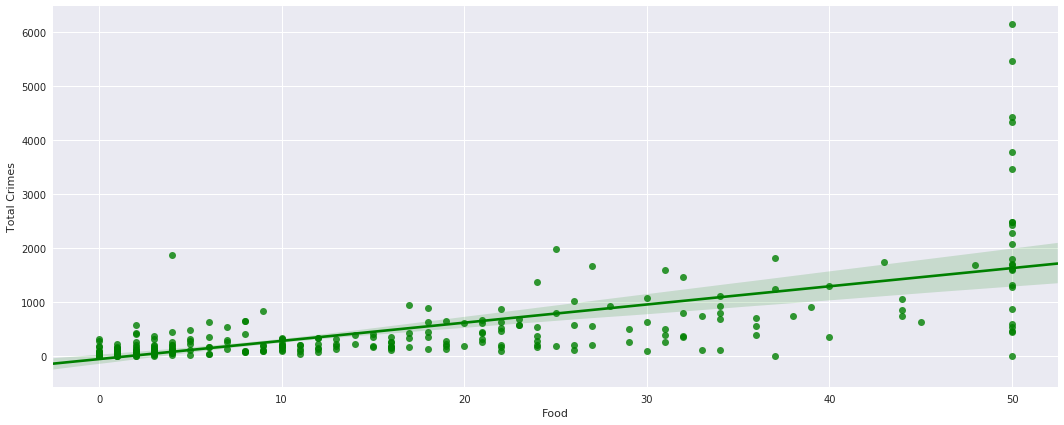

In [312]:
ax = sns.regplot(x='Food', y='Total Crimes', data=analysis_df, color='green')

### Total Crimes vs Nightlife Spot venues

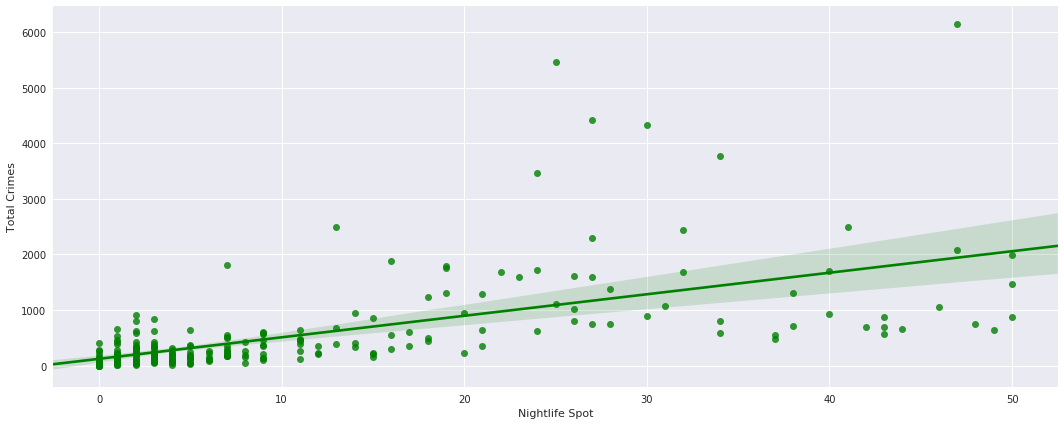

In [315]:
ax = sns.regplot(x='Nightlife Spot', y='Total Crimes', data=analysis_df, color='green')

### Total Crimes vs Residence venues

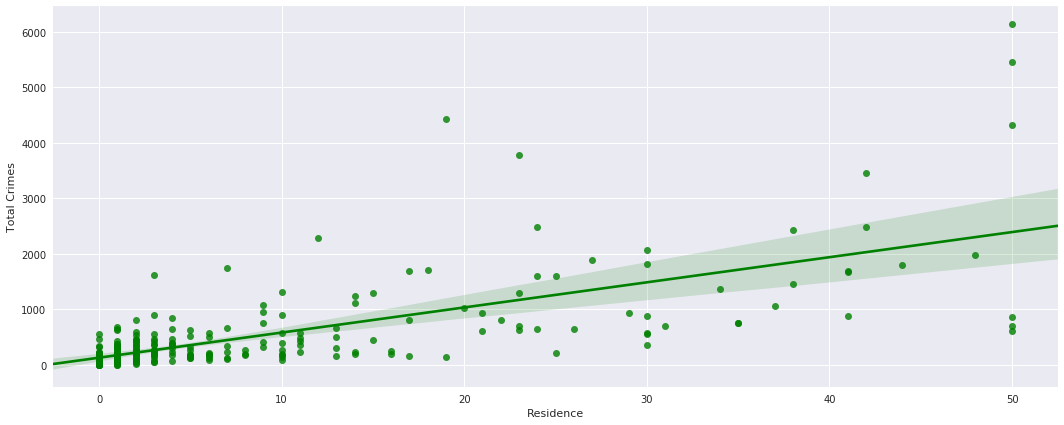

In [316]:
ax = sns.regplot(x='Residence', y='Total Crimes', data=analysis_df, color='green')

# Creating a regression model based on the key parameters

## Model type selection

Let's evaluate 3 different models - linear regression, multiple linear regression and polynomial fit.

## Linear regression

First let's build a linear model.

In [362]:
x = analysis_df['Total Venues']
y = analysis_df['Total Crimes']

# build the model
f = np.polyfit(x, y, 1)
p = np.poly1d(f)
print(p)

 
5.781 x - 224.1


Define a function to help us plot.

In [363]:
def PlotPolly(model, independent_variable, dependent_variable, Name, plot_title):
    x_new = np.linspace(0, 400, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    plt.title(plot_title)
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Total Crimes')

    plt.show()
    plt.close()

Let's plot the function against the data.

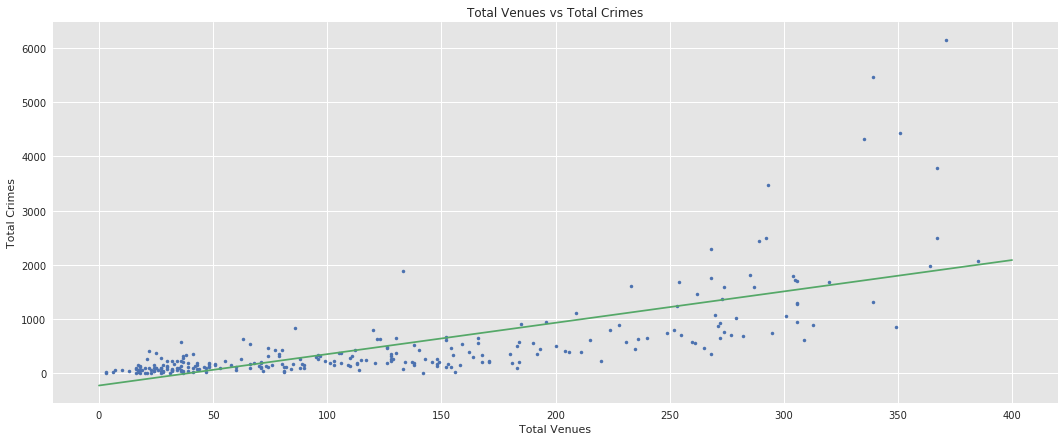

In [364]:
PlotPolly(p, x, y, 'Total Venues', 'Total Venues vs Total Crimes')

Let's look at a residual plot to see whether a linear model is likely to work well.

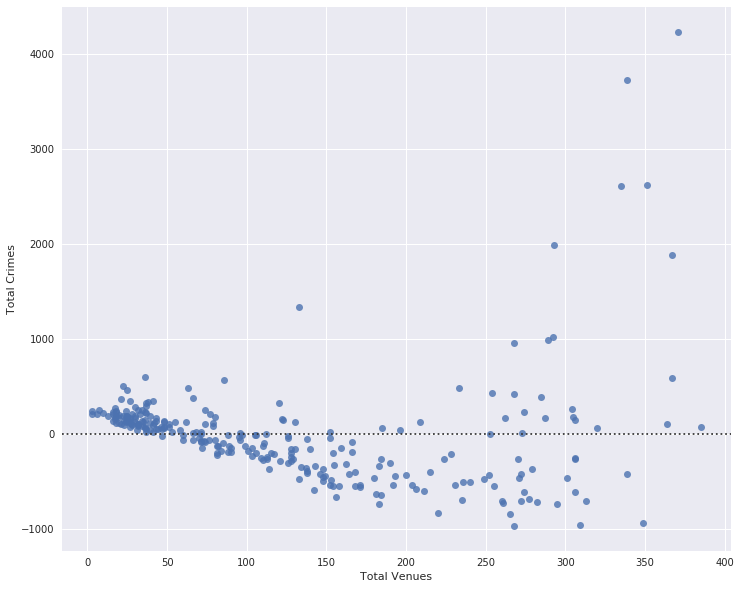

In [365]:
plt.figure(figsize=(12, 10))
sns.residplot(analysis_df['Total Venues'], analysis_df['Total Crimes'])
plt.show()

We can see that the points are not evenly distributed above and below 0, meaning that other models are likely to work better.

Let's calculate the R-squared fit.

In [366]:
from sklearn.metrics import r2_score
r_squared = r2_score(y, p(x))
print('R-squared is: ', r_squared)

R-squared is:  0.502358210859


## Multiple Linear Regression
First define the variables to use (based on those we identified earlier).

In [367]:
Z = analysis_df[['Arts and Entertainment', 'Food', 'Nightlife Spot', 'Residence']]

Fit the model.

In [368]:
lm.fit(Z, analysis_df['Total Crimes'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [369]:
# Get the intercept
lm.intercept_

-63.129221529777226

In [370]:
# Get the parameters for each input
lm.coef_

array([  8.7062263 ,  16.31905148,  -4.58273384,  29.26167973])

Let's look at the distribution plot.

In [371]:
Y_hat = lm.predict(Z)

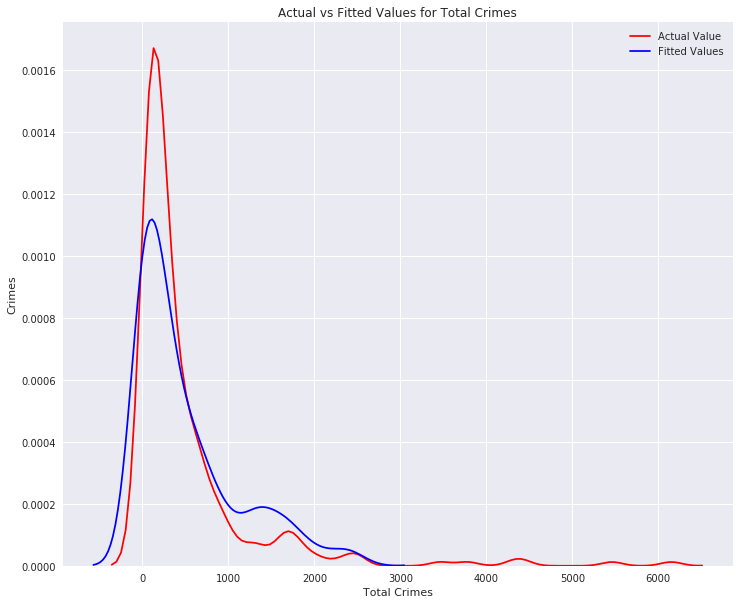

In [372]:
plt.figure(figsize=(12, 10))


ax1 = sns.distplot(analysis_df['Total Crimes'], hist=False, color="r", label="Actual Value")
sns.distplot(Y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Total Crimes')
plt.xlabel('Total Crimes')
plt.ylabel('Crimes')

plt.show()
plt.close()

Let's calculate the R-squared

In [373]:
print('The R-square is: ', lm.score(Z, analysis_df['Total Crimes']))

The R-square is:  0.564095529376


## Polynomial Fit

First build a polynomial model, starting with order 3.

In [374]:
# get the variables
x = analysis_df['Total Venues']
y = analysis_df['Total Crimes']

In [375]:
# build the model
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

           3           2
0.0001464 x - 0.04499 x + 5.789 x - 11.4


Let's plot it.

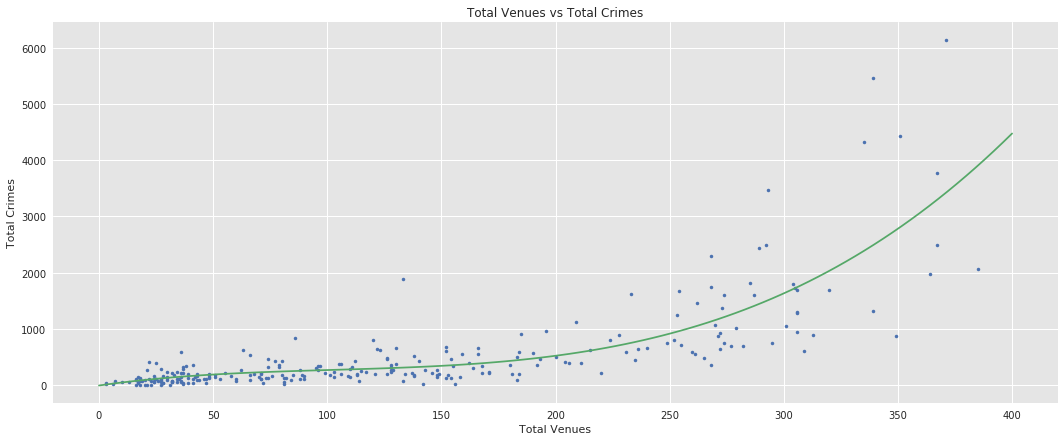

In [376]:
PlotPolly(p, x, y, 'Total Venues', 'Total Venues vs Total Crimes')

Looks pretty good. Let's calculate the R-squared fit.

In [377]:
r_squared = r2_score(y, p(x))
print('R-squared is: ', r_squared)

R-squared is:  0.661064573049


## Comparing the models

Comparing the R-squared values.

| Model | R-Square |
|-------|----------|
| Single Linear Regression   | 0.502358210859 |
| Multiple Linear Regression | 0.564095529376 |
| Polynomial fit             | 0.661064573049 |

The polynomial fit (based on the total number of venues) provdes the strongest fit here and can explain 66% of the variation in the total number of crimes in a district.